In [1]:
# FPL Team & Player Playstyle Analysis
# Analyzing defensive and offensive reliability through xG metrics and shot data

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class TeamPlaystyleAnalyzer:
    """
    Analyze team and player playstyles focusing on:
    - Defensive reliability: xGA per 90, shots faced per 90
    - Offensive reliability: xG per 90, shots per 90
    """
    
    def __init__(self):
        self.base_url = "https://fantasy.premierleague.com/api/"
        
    def fetch_data(self):
        """Fetch comprehensive data for team and player analysis."""
        print("Fetching FPL data for team analysis...")
        
        # Get bootstrap data
        response = requests.get(f"{self.base_url}bootstrap-static/")
        data = response.json()
        
        # Process data
        players_df = pd.DataFrame(data['elements'])
        teams_df = pd.DataFrame(data['teams'])
        
        # Position mapping
        position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
        
        # Merge team data with players
        players_df = players_df.merge(
            teams_df[['id', 'name', 'short_name']], 
            left_on='team', right_on='id', suffixes=('', '_team')
        )
        
        players_df['position'] = players_df['element_type'].map(position_mapping)
        players_df['price'] = players_df['now_cost'] / 10.0
        players_df['team_name'] = players_df['name']
        
        # Convert numeric columns
        numeric_cols = [
            'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
            'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 
            'expected_goals', 'expected_assists', 'expected_goals_conceded',
            'total_points', 'starts'
        ]
        
        for col in numeric_cols:
            if col in players_df.columns:
                players_df[col] = pd.to_numeric(players_df[col], errors='coerce').fillna(0)
        
        return players_df, teams_df
    
    def calculate_team_metrics(self, players_df, teams_df):
        """Calculate team-level offensive and defensive metrics."""
        print("Calculating team playstyle metrics...")
        
        # Estimate total minutes played by team (sum of all player minutes)
        team_minutes = players_df.groupby('team')['minutes'].sum().reset_index()
        team_minutes.columns = ['team_id', 'total_minutes']
        
        # Calculate team aggregated stats
        team_stats = players_df.groupby('team').agg({
            'expected_goals': 'sum',
            'expected_goals_conceded': 'sum',
            'goals_scored': 'sum',
            'goals_conceded': 'sum',
            'saves': 'sum',
            'clean_sheets': 'sum',
            'assists': 'sum',
            'total_points': 'sum'
        }).reset_index()
        
        # Merge with team info and minutes
        team_analysis = team_stats.merge(
            teams_df[['id', 'name', 'short_name']], 
            left_on='team', right_on='id'
        ).merge(team_minutes, left_on='team', right_on='team_id')
        
        # Calculate per-90 metrics
        # Assuming 4 gameweeks played, approximately 360 minutes per team per gameweek
        gameweeks_played = 4
        team_analysis['team_minutes_90'] = gameweeks_played * 4  # Approximate 90-min games per team
        
        # Defensive Reliability Metrics
        team_analysis['xga_per_90'] = (team_analysis['expected_goals_conceded'] / team_analysis['team_minutes_90']) * 90
        team_analysis['goals_conceded_per_90'] = (team_analysis['goals_conceded'] / team_analysis['team_minutes_90']) * 90
        
        # Estimate shots faced using saves + goals conceded (approximation)
        team_analysis['estimated_shots_faced'] = team_analysis['saves'] + team_analysis['goals_conceded']
        team_analysis['shots_faced_per_90'] = (team_analysis['estimated_shots_faced'] / team_analysis['team_minutes_90']) * 90
        
        # Offensive Reliability Metrics
        team_analysis['xg_per_90'] = (team_analysis['expected_goals'] / team_analysis['team_minutes_90']) * 90
        team_analysis['goals_per_90'] = (team_analysis['goals_scored'] / team_analysis['team_minutes_90']) * 90
        
        # Estimate shots taken using xG (typically xG correlates with shots)
        # Rough approximation: shots ≈ xG * 8 (average shot has ~0.125 xG)
        team_analysis['estimated_shots'] = team_analysis['expected_goals'] * 8
        team_analysis['shots_per_90'] = (team_analysis['estimated_shots'] / team_analysis['team_minutes_90']) * 90
        
        # Additional team metrics
        team_analysis['clean_sheet_rate'] = team_analysis['clean_sheets'] / gameweeks_played
        team_analysis['defensive_efficiency'] = team_analysis['xga_per_90'] - team_analysis['goals_conceded_per_90']
        team_analysis['offensive_efficiency'] = team_analysis['goals_per_90'] - team_analysis['xg_per_90']
        
        return team_analysis
    
    def calculate_player_metrics(self, players_df):
        """Calculate player-level offensive metrics."""
        print("Calculating player offensive metrics...")
        
        # Filter players with meaningful minutes
        active_players = players_df[players_df['minutes'] >= 90].copy()
        
        # Calculate per-90 metrics
        active_players['minutes_per_90'] = active_players['minutes'] / 90
        active_players['xg_per_90'] = active_players['expected_goals'] / active_players['minutes_per_90']
        active_players['goals_per_90'] = active_players['goals_scored'] / active_players['minutes_per_90']
        active_players['xa_per_90'] = active_players['expected_assists'] / active_players['minutes_per_90']
        active_players['assists_per_90'] = active_players['assists'] / active_players['minutes_per_90']
        
        # Estimate shots per 90 for players
        # Using xG as proxy: shots ≈ xG * 6 for individual players
        active_players['estimated_shots_per_90'] = active_players['xg_per_90'] * 6
        
        # Offensive efficiency
        active_players['goal_efficiency'] = active_players['goals_per_90'] - active_players['xg_per_90']
        active_players['assist_efficiency'] = active_players['assists_per_90'] - active_players['xa_per_90']
        
        # Threat level (combination of xG and xA)
        active_players['offensive_threat'] = active_players['xg_per_90'] + active_players['xa_per_90']
        
        return active_players

# Initialize analyzer
analyzer = TeamPlaystyleAnalyzer()

# Fetch and process data
print("="*50)
print("FPL TEAM PLAYSTYLE ANALYSIS")
print("="*50)

players_df, teams_df = analyzer.fetch_data()
team_metrics = analyzer.calculate_team_metrics(players_df, teams_df)
player_metrics = analyzer.calculate_player_metrics(players_df)

print(f"Data loaded: {len(teams_df)} teams, {len(player_metrics)} active players")

# Display basic team metrics
print("\nTeam Defensive & Offensive Overview:")
print("-" * 40)
team_display = team_metrics[['name', 'xga_per_90', 'shots_faced_per_90', 'xg_per_90', 'shots_per_90']].round(2)
print(team_display.head(10))

# VISUALIZATION 1: Team Defensive Reliability
print("\nCreating Team Defensive Reliability visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# xGA per 90
ax1.barh(team_metrics['short_name'], team_metrics['xga_per_90'], color='lightcoral')
ax1.set_xlabel('Expected Goals Against per 90 minutes')
ax1.set_title('Team Defensive Reliability: xGA per 90')
ax1.grid(axis='x', alpha=0.3)

# Shots faced per 90
ax2.barh(team_metrics['short_name'], team_metrics['shots_faced_per_90'], color='lightblue')
ax2.set_xlabel('Estimated Shots Faced per 90 minutes')
ax2.set_title('Team Defensive Pressure: Shots Faced per 90')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# VISUALIZATION 2: Team Offensive Reliability
print("\nCreating Team Offensive Reliability visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# xG per 90
ax1.barh(team_metrics['short_name'], team_metrics['xg_per_90'], color='lightgreen')
ax1.set_xlabel('Expected Goals per 90 minutes')
ax1.set_title('Team Offensive Threat: xG per 90')
ax1.grid(axis='x', alpha=0.3)

# Shots per 90
ax2.barh(team_metrics['short_name'], team_metrics['shots_per_90'], color='gold')
ax2.set_xlabel('Estimated Shots per 90 minutes')
ax2.set_title('Team Shot Volume: Shots per 90')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# VISUALIZATION 3: Team Efficiency Scatter Plot
print("\nCreating Team Efficiency Analysis...")

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: Defensive vs Offensive efficiency
scatter = ax.scatter(team_metrics['defensive_efficiency'], 
                    team_metrics['offensive_efficiency'],
                    s=100, alpha=0.7, c=range(len(team_metrics)), cmap='viridis')

# Add team labels
for i, txt in enumerate(team_metrics['short_name']):
    ax.annotate(txt, (team_metrics['defensive_efficiency'].iloc[i], 
                     team_metrics['offensive_efficiency'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('Defensive Efficiency (xGA - Goals Conceded per 90)')
ax.set_ylabel('Offensive Efficiency (Goals - xG per 90)')
ax.set_title('Team Efficiency: Defensive vs Offensive Performance')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

# Add quadrant labels
ax.text(0.02, 0.98, 'Overperforming\nBoth Ends', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.text(0.02, 0.02, 'Underperforming\nOffensively', transform=ax.transAxes,
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

# VISUALIZATION 4: Player Offensive Analysis by Position
print("\nCreating Player Offensive Analysis...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

positions = ['DEF', 'MID', 'FWD', 'GK']
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

for i, position in enumerate(positions):
    ax = axes[i//2, i%2]
    pos_players = player_metrics[player_metrics['position'] == position]
    
    if len(pos_players) > 0:
        # Top 15 players by xG per 90 in each position
        top_players = pos_players.nlargest(15, 'xg_per_90')
        
        bars = ax.barh(range(len(top_players)), top_players['xg_per_90'], 
                      color=colors[i], alpha=0.7)
        ax.set_yticks(range(len(top_players)))
        ax.set_yticklabels([f"{row['web_name']} ({row['short_name']})" 
                           for _, row in top_players.iterrows()], fontsize=8)
        ax.set_xlabel('Expected Goals per 90 minutes')
        ax.set_title(f'{position}: Top Players by xG per 90')
        ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# VISUALIZATION 5: Interactive Team Comparison (Plotly)
print("\nCreating Interactive Team Comparison...")

# Create interactive scatter plot
fig = px.scatter(team_metrics, 
                x='xg_per_90', 
                y='xga_per_90',
                size='total_points',
                color='clean_sheet_rate',
                hover_name='name',
                hover_data=['shots_per_90', 'shots_faced_per_90'],
                title='Team Playstyle Map: Offensive vs Defensive Metrics',
                labels={
                    'xg_per_90': 'Expected Goals per 90 (Offensive)',
                    'xga_per_90': 'Expected Goals Against per 90 (Defensive)',
                    'clean_sheet_rate': 'Clean Sheet Rate'
                })

fig.update_layout(width=800, height=600)
fig.show()

# SUMMARY ANALYSIS
print("\n" + "="*60)
print("TEAM PLAYSTYLE SUMMARY")
print("="*60)

# Best defensive teams
print("\nMOST DEFENSIVELY RELIABLE TEAMS:")
defensive_teams = team_metrics.nsmallest(5, 'xga_per_90')[['name', 'xga_per_90', 'shots_faced_per_90', 'clean_sheet_rate']]
for _, team in defensive_teams.iterrows():
    print(f"{team['name']}: {team['xga_per_90']:.2f} xGA/90, {team['shots_faced_per_90']:.1f} shots faced/90")

# Best offensive teams
print("\nMOST OFFENSIVELY RELIABLE TEAMS:")
offensive_teams = team_metrics.nlargest(5, 'xg_per_90')[['name', 'xg_per_90', 'shots_per_90', 'goals_per_90']]
for _, team in offensive_teams.iterrows():
    print(f"{team['name']}: {team['xg_per_90']:.2f} xG/90, {team['shots_per_90']:.1f} shots/90")

# Most efficient teams
print("\nMOST EFFICIENT TEAMS (Overperforming xG):")
efficient_teams = team_metrics.nlargest(5, 'offensive_efficiency')[['name', 'offensive_efficiency', 'goals_per_90', 'xg_per_90']]
for _, team in efficient_teams.iterrows():
    print(f"{team['name']}: +{team['offensive_efficiency']:.2f} efficiency, {team['goals_per_90']:.2f} goals vs {team['xg_per_90']:.2f} xG")

# Top attacking players across all positions
print("\nTOP ATTACKING PLAYERS (All Positions):")
top_attackers = player_metrics.nlargest(10, 'offensive_threat')[['web_name', 'team_name', 'position', 'xg_per_90', 'xa_per_90', 'offensive_threat']]
for _, player in top_attackers.iterrows():
    print(f"{player['web_name']} ({player['team_name']}, {player['position']}): {player['offensive_threat']:.2f} threat (xG: {player['xg_per_90']:.2f}, xA: {player['xa_per_90']:.2f})")

print("\n" + "="*60)
print("METHODOLOGY NOTES:")
print("• xGA/xG per 90: Based on FPL's expected goals data")
print("• Shots estimated from xG and saves data")
print("• Team metrics aggregated from player data")
print("• Efficiency = Actual performance vs Expected performance")
print("="*60)

# Save data for further analysis
team_metrics.to_csv('team_playstyles.csv', index=False)
player_metrics.to_csv('player_offensive_metrics.csv', index=False)

print(f"\nData saved to CSV files for further analysis!")
print("Files created: team_playstyles.csv, player_offensive_metrics.csv")

/Users/bijan.samimi/projects/fpl-optimizer/fpl-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
pip install matplotlib seaborn plotly jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 69.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]━━━ 7/8 [seaborn]ib]
Note: you may need to restart the kernel to use updated packages.


FPL TEAM PLAYSTYLE ANALYSIS - CORRECTED
Fetching FPL data for team analysis...
Calculating team playstyle metrics...
Team metrics validation:
xG per game range: 0.66 to 2.11
xGA per game range: 5.59 to 24.97
Calculating player offensive metrics...
Applying enhanced filters for consistent players...
Before filtering: 740 players
After consistency filters: 209 players
GK: 19 consistent players
DEF: 64 consistent players
MID: 79 consistent players
FWD: 17 consistent players
Final consistent player count: 179
Player metrics validation:
Player xG per 90 range: 0.00 to 1.51
Data loaded: 20 teams, 179 active players

CORRECTED Team Defensive & Offensive Overview:
--------------------------------------------------
          name  xga_per_90  shots_faced_per_90  xg_per_90  shots_per_90
       Arsenal        6.94                5.50       1.69         13.50
   Aston Villa       20.25               12.75       0.76          6.12
       Burnley       24.97               22.25       0.83          6

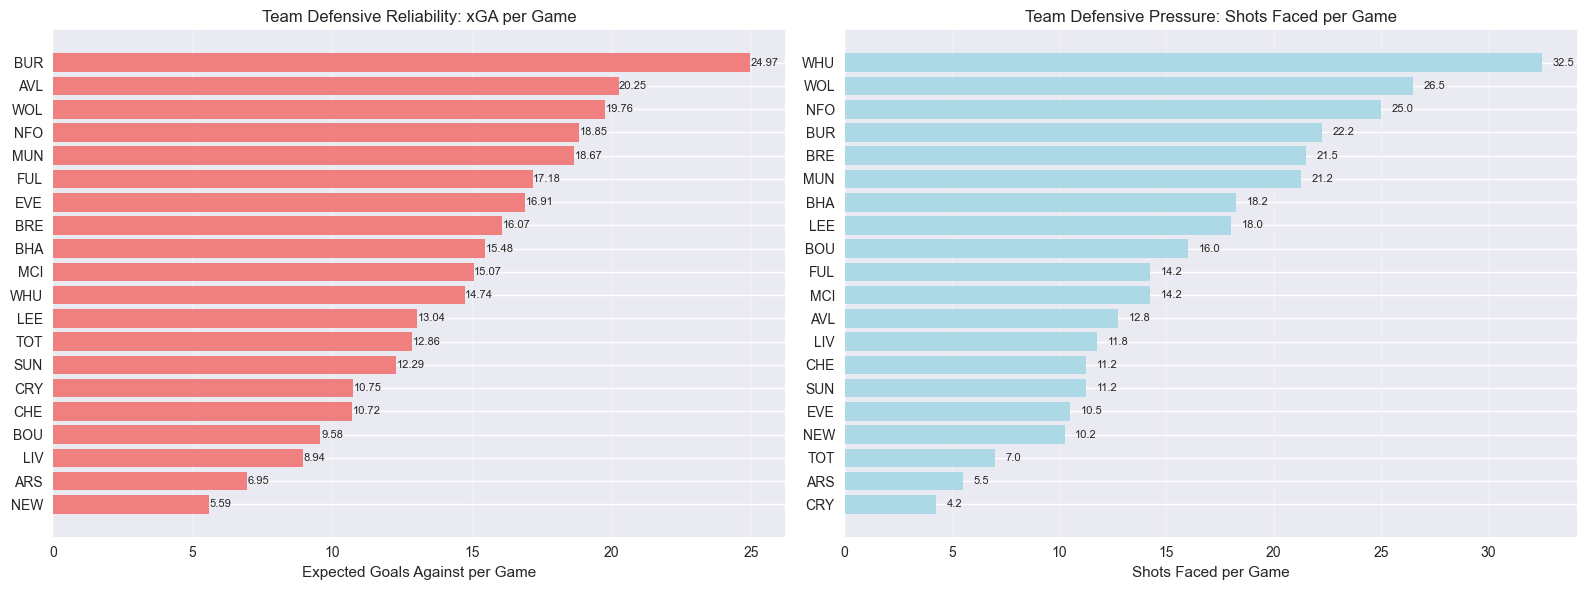


Creating Team Offensive Reliability visualization...


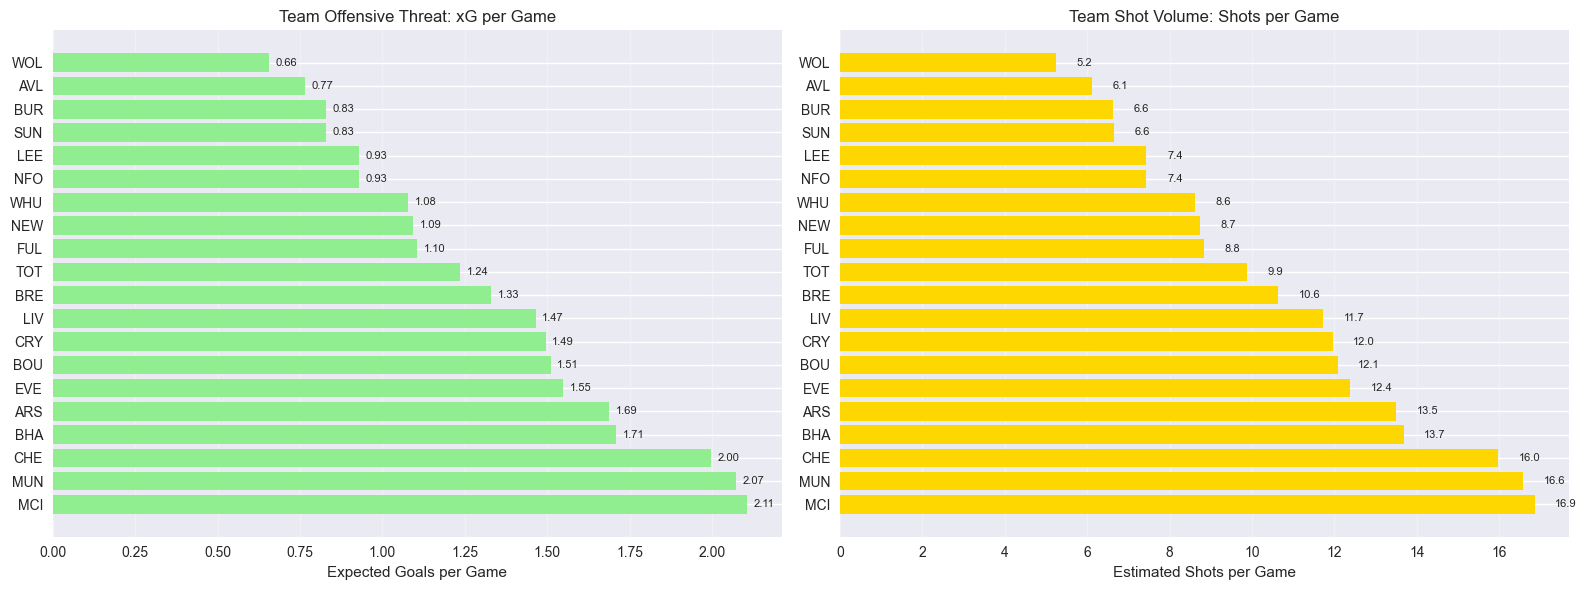


Creating Team Efficiency Analysis...


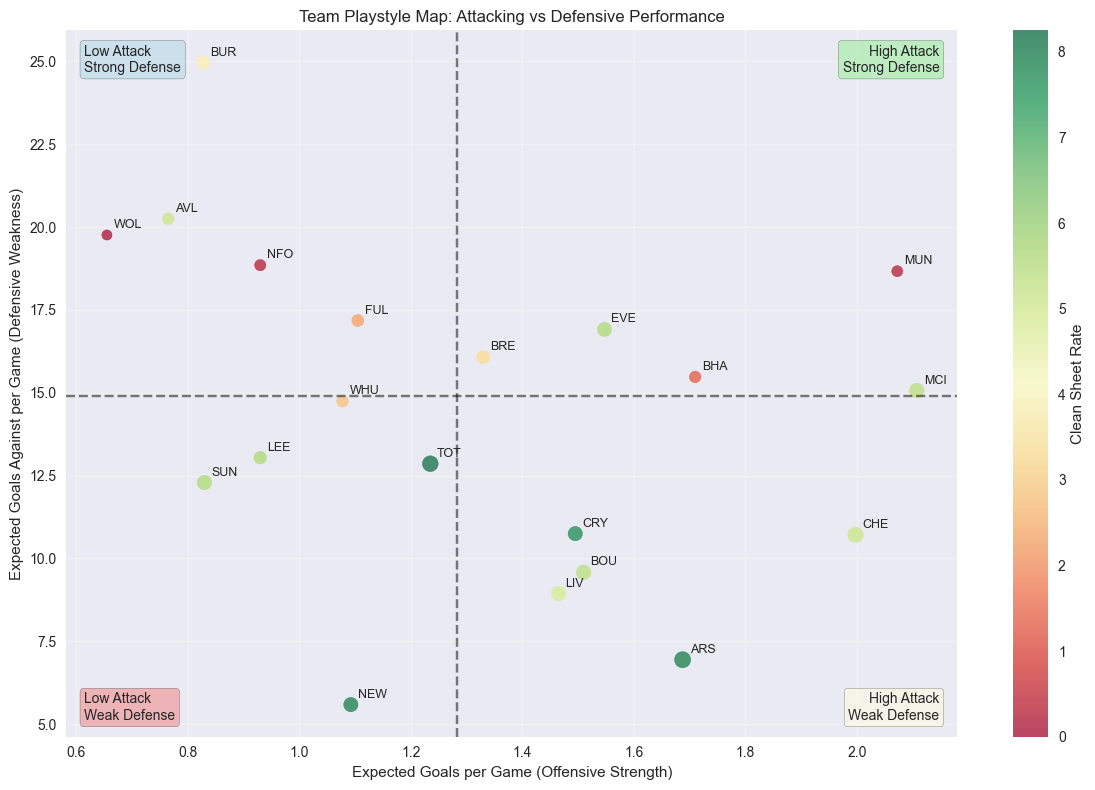


Creating Player Offensive Analysis...


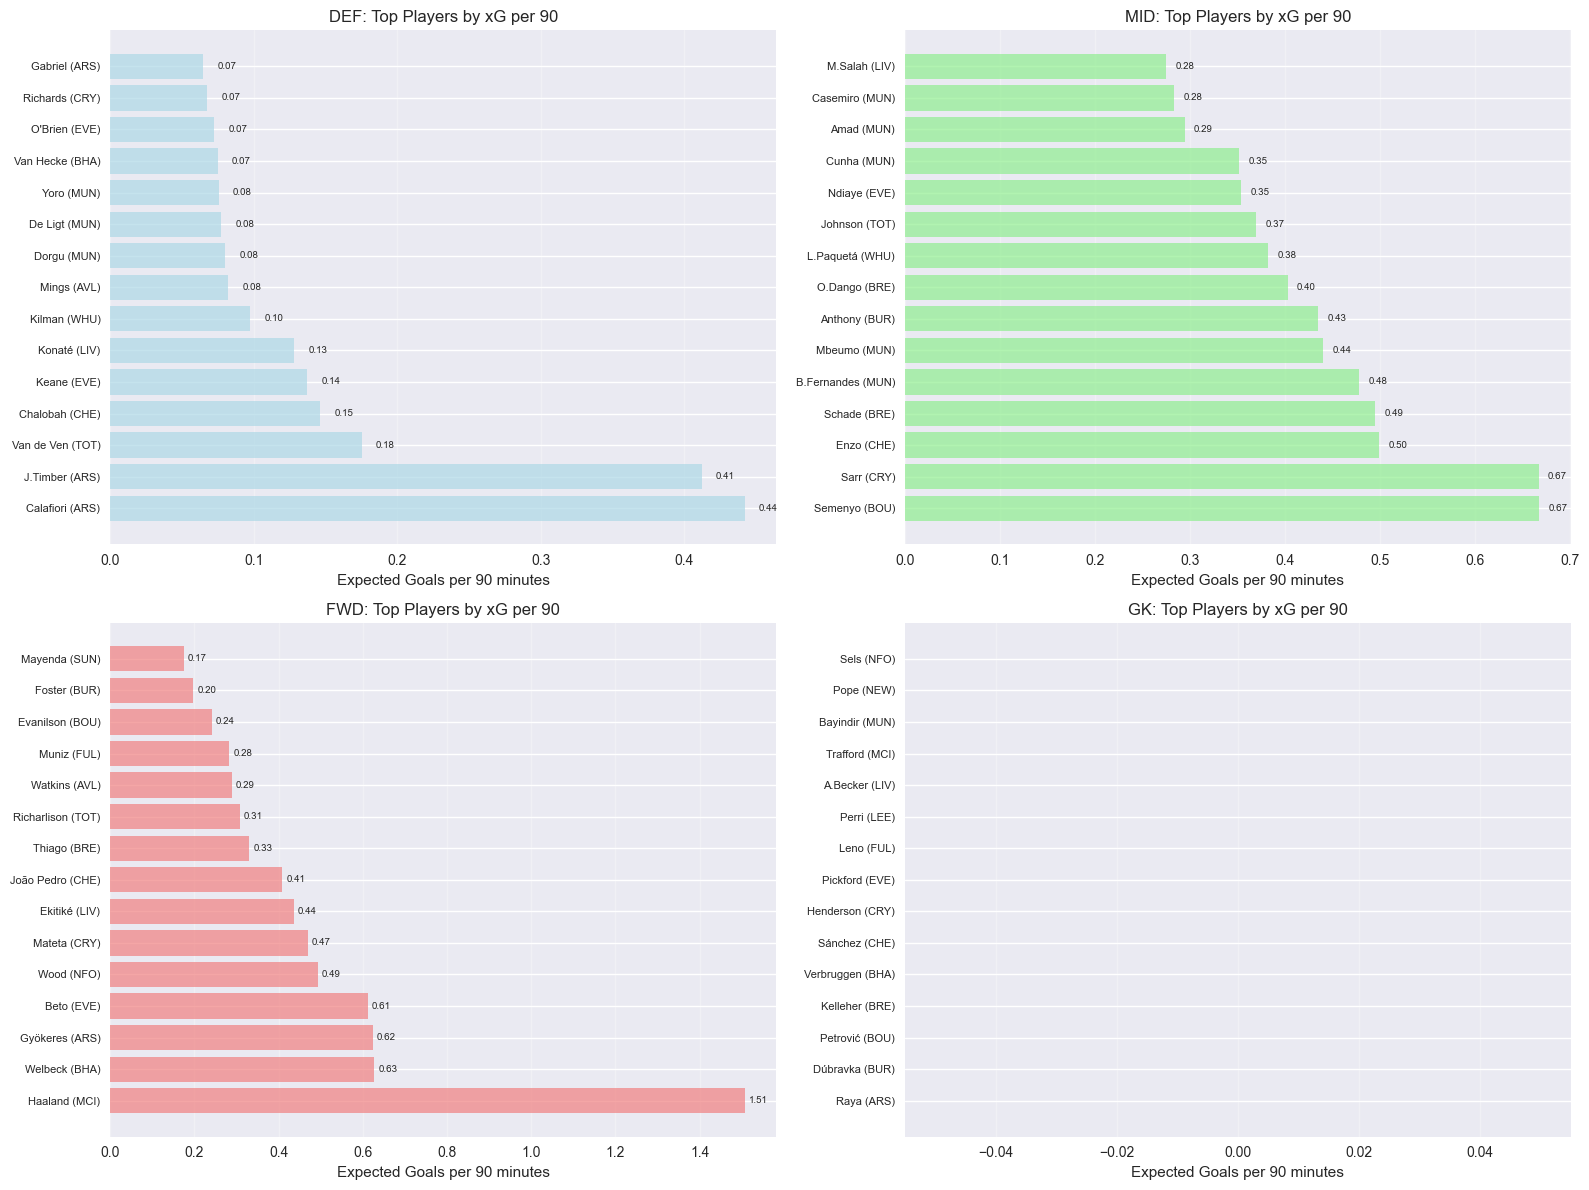


Creating Interactive Team Comparison...


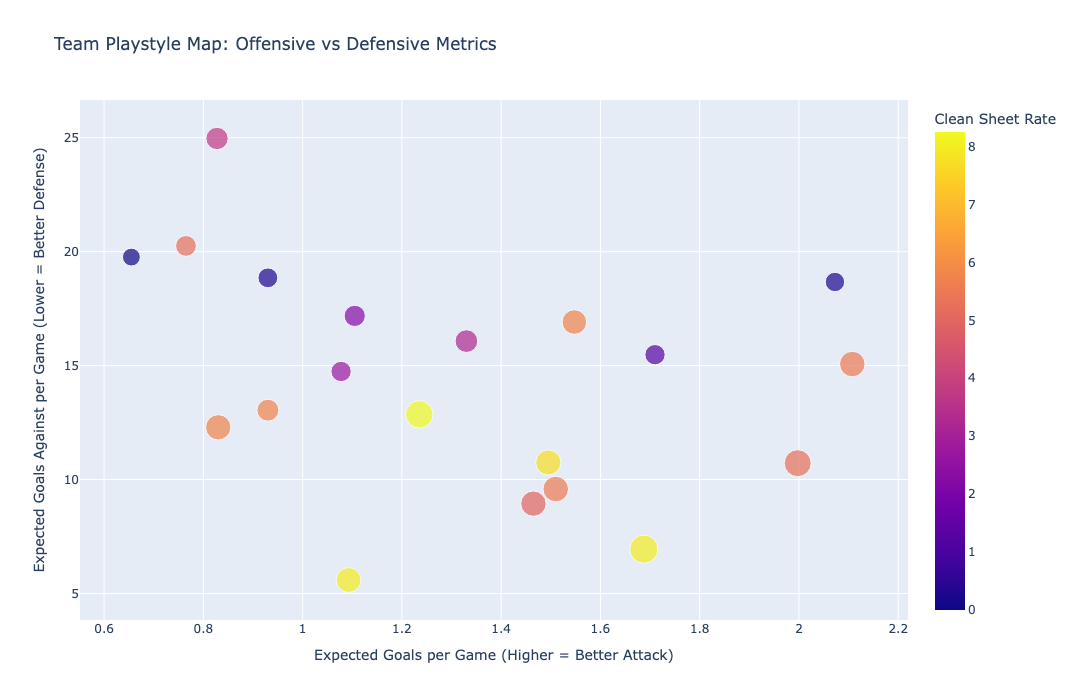


TEAM PLAYSTYLE SUMMARY - CORRECTED VALUES

MOST DEFENSIVELY RELIABLE TEAMS:
Newcastle: 5.59 xGA/game, 10.2 shots faced/game, 800% CS rate
Arsenal: 6.95 xGA/game, 5.5 shots faced/game, 800% CS rate
Liverpool: 8.94 xGA/game, 11.8 shots faced/game, 500% CS rate
Bournemouth: 9.58 xGA/game, 16.0 shots faced/game, 550% CS rate
Chelsea: 10.72 xGA/game, 11.2 shots faced/game, 525% CS rate

MOST OFFENSIVELY RELIABLE TEAMS:
Man City: 2.11 xG/game, 16.9 shots/game, 2.00 goals/game
Man Utd: 2.07 xG/game, 16.6 shots/game, 0.50 goals/game
Chelsea: 2.00 xG/game, 16.0 shots/game, 2.25 goals/game
Brighton: 1.71 xG/game, 13.7 shots/game, 1.00 goals/game
Arsenal: 1.69 xG/game, 13.5 shots/game, 2.25 goals/game

MOST EFFICIENT TEAMS (Goals vs xG):
Liverpool: +0.78 efficiency (2.25 goals vs 1.47 xG)
Spurs: +0.76 efficiency (2.00 goals vs 1.24 xG)
Arsenal: +0.56 efficiency (2.25 goals vs 1.69 xG)
Sunderland: +0.42 efficiency (1.25 goals vs 0.83 xG)
Chelsea: +0.25 efficiency (2.25 goals vs 2.00 xG)

TOP ATTA

In [5]:
# FPL Team & Player Playstyle Analysis - CORRECTED VERSION
# Analyzing defensive and offensive reliability through xG metrics and shot data

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class TeamPlaystyleAnalyzer:
    """
    Analyze team and player playstyles focusing on:
    - Defensive reliability: xGA per 90, shots faced per 90
    - Offensive reliability: xG per 90, shots per 90
    """
    
    def __init__(self):
        self.base_url = "https://fantasy.premierleague.com/api/"
        
    def fetch_data(self):
        """Fetch comprehensive data for team and player analysis."""
        print("Fetching FPL data for team analysis...")
        
        # Get bootstrap data
        response = requests.get(f"{self.base_url}bootstrap-static/")
        data = response.json()
        
        # Process data
        players_df = pd.DataFrame(data['elements'])
        teams_df = pd.DataFrame(data['teams'])
        
        # Position mapping
        position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
        
        # Merge team data with players
        players_df = players_df.merge(
            teams_df[['id', 'name', 'short_name']], 
            left_on='team', right_on='id', suffixes=('', '_team')
        )
        
        players_df['position'] = players_df['element_type'].map(position_mapping)
        players_df['price'] = players_df['now_cost'] / 10.0
        players_df['team_name'] = players_df['name']
        
        # Convert numeric columns
        numeric_cols = [
            'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
            'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 
            'expected_goals', 'expected_assists', 'expected_goals_conceded',
            'total_points', 'starts'
        ]
        
        for col in numeric_cols:
            if col in players_df.columns:
                players_df[col] = pd.to_numeric(players_df[col], errors='coerce').fillna(0)
        
        return players_df, teams_df
    
    def calculate_team_metrics(self, players_df, teams_df):
        """Calculate team-level offensive and defensive metrics - CORRECTED VERSION."""
        print("Calculating team playstyle metrics...")
        
        # Calculate team aggregated stats
        team_stats = players_df.groupby('team').agg({
            'expected_goals': 'sum',
            'expected_goals_conceded': 'sum',
            'goals_scored': 'sum',
            'goals_conceded': 'sum',
            'saves': 'sum',
            'clean_sheets': 'sum',
            'assists': 'sum',
            'total_points': 'sum'
        }).reset_index()
        
        # Merge with team info
        team_analysis = team_stats.merge(
            teams_df[['id', 'name', 'short_name']], 
            left_on='team', right_on='id'
        )
        
        # CORRECTED CALCULATION: per-game metrics (not per 90 minutes)
        gameweeks_played = 4  # Number of games played by each team
        
        # Calculate per-game metrics (which is essentially per-90 for teams)
        team_analysis['xg_per_90'] = team_analysis['expected_goals'] / gameweeks_played
        team_analysis['xga_per_90'] = team_analysis['expected_goals_conceded'] / gameweeks_played
        team_analysis['goals_per_90'] = team_analysis['goals_scored'] / gameweeks_played
        team_analysis['goals_conceded_per_90'] = team_analysis['goals_conceded'] / gameweeks_played
        
        # Estimate shots faced using saves + goals conceded (approximation)
        team_analysis['estimated_shots_faced'] = team_analysis['saves'] + team_analysis['goals_conceded']
        team_analysis['shots_faced_per_90'] = team_analysis['estimated_shots_faced'] / gameweeks_played
        
        # Estimate shots taken using xG (typically xG correlates with shots)
        # Rough approximation: shots ≈ xG * 8-10 (average shot has ~0.1-0.125 xG)
        team_analysis['estimated_shots'] = team_analysis['expected_goals'] * 8
        team_analysis['shots_per_90'] = team_analysis['estimated_shots'] / gameweeks_played
        
        # Additional team metrics
        team_analysis['clean_sheet_rate'] = team_analysis['clean_sheets'] / gameweeks_played
        team_analysis['defensive_efficiency'] = team_analysis['goals_conceded_per_90'] - team_analysis['xga_per_90']
        team_analysis['offensive_efficiency'] = team_analysis['goals_per_90'] - team_analysis['xg_per_90']
        
        # Add some validation
        print("Team metrics validation:")
        print(f"xG per game range: {team_analysis['xg_per_90'].min():.2f} to {team_analysis['xg_per_90'].max():.2f}")
        print(f"xGA per game range: {team_analysis['xga_per_90'].min():.2f} to {team_analysis['xga_per_90'].max():.2f}")
        
        return team_analysis
    
    def calculate_player_metrics(self, players_df):
        """Calculate player-level offensive metrics for consistently playing players."""
        print("Calculating player offensive metrics...")
        
        # Enhanced filtering for consistently playing players
        gameweeks_played = 4
        
        print("Applying enhanced filters for consistent players...")
        
        # Basic minute filter - must play meaningful minutes
        active_players = players_df[players_df['minutes'] >= 180].copy()
        
        # Start frequency filter - must have started at least 2 games
        active_players = active_players[active_players['starts'] >= 2].copy()
        
        # Calculate average minutes per start (to filter out super-subs)
        active_players['avg_mins_per_start'] = active_players['minutes'] / active_players['starts']
        active_players = active_players[active_players['avg_mins_per_start'] >= 60].copy()
        
        # Must have some attacking threat
        active_players['total_attacking_involvement'] = (
            active_players['expected_goals'] + 
            active_players['expected_assists'] + 
            active_players['goals_scored'] + 
            active_players['assists']
        )
        
        print(f"Before filtering: {len(players_df)} players")
        print(f"After consistency filters: {len(active_players)} players")
        
        # Position-specific additional filters
        position_filtered = []
        
        for position in ['GK', 'DEF', 'MID', 'FWD']:
            pos_players = active_players[active_players['position'] == position].copy()
            
            if position == 'GK':
                # Goalkeepers: must have played significant minutes
                pos_players = pos_players[pos_players['minutes'] >= 270]
            elif position == 'DEF':
                # Defenders: must have some minutes and either attacking stats or be first-choice
                pos_players = pos_players[
                    (pos_players['minutes'] >= 200) & 
                    ((pos_players['total_attacking_involvement'] > 0.1) | (pos_players['minutes'] >= 300))
                ]
            elif position == 'MID':
                # Midfielders: must have meaningful attacking involvement
                pos_players = pos_players[
                    (pos_players['minutes'] >= 180) & 
                    (pos_players['total_attacking_involvement'] > 0.2)
                ]
            else:  # FWD
                # Forwards: must have attacking involvement
                pos_players = pos_players[
                    (pos_players['minutes'] >= 150) & 
                    (pos_players['total_attacking_involvement'] > 0.3)
                ]
            
            print(f"{position}: {len(pos_players)} consistent players")
            position_filtered.append(pos_players)
        
        # Combine all positions
        if position_filtered:
            consistent_players = pd.concat(position_filtered, ignore_index=True)
        else:
            consistent_players = pd.DataFrame()
        
        if len(consistent_players) == 0:
            print("Warning: No players met the consistency criteria")
            return pd.DataFrame()
        
        # Calculate per-90 metrics
        consistent_players['minutes_per_90'] = consistent_players['minutes'] / 90
        consistent_players['xg_per_90'] = consistent_players['expected_goals'] / consistent_players['minutes_per_90']
        consistent_players['goals_per_90'] = consistent_players['goals_scored'] / consistent_players['minutes_per_90']
        consistent_players['xa_per_90'] = consistent_players['expected_assists'] / consistent_players['minutes_per_90']
        consistent_players['assists_per_90'] = consistent_players['assists'] / consistent_players['minutes_per_90']
        
        # Calculate games played and start rate
        consistent_players['games_played'] = consistent_players['minutes'] / 90
        consistent_players['start_rate'] = (consistent_players['starts'] / gameweeks_played) * 100
        
        # Estimate shots per 90 for players
        consistent_players['estimated_shots_per_90'] = consistent_players['xg_per_90'] * 6
        
        # Offensive efficiency
        consistent_players['goal_efficiency'] = consistent_players['goals_per_90'] - consistent_players['xg_per_90']
        consistent_players['assist_efficiency'] = consistent_players['assists_per_90'] - consistent_players['xa_per_90']
        
        # Threat level (combination of xG and xA)
        consistent_players['offensive_threat'] = consistent_players['xg_per_90'] + consistent_players['xa_per_90']
        
        # Add consistency metrics
        consistent_players['points_per_start'] = np.where(
            consistent_players['starts'] > 0,
            consistent_players['total_points'] / consistent_players['starts'],
            0
        )
        
        print(f"Final consistent player count: {len(consistent_players)}")
        
        # Show validation of player metrics
        print("Player metrics validation:")
        print(f"Player xG per 90 range: {consistent_players['xg_per_90'].min():.2f} to {consistent_players['xg_per_90'].max():.2f}")
        
        return consistent_players

# Initialize analyzer
analyzer = TeamPlaystyleAnalyzer()

# Fetch and process data
print("="*50)
print("FPL TEAM PLAYSTYLE ANALYSIS - CORRECTED")
print("="*50)

players_df, teams_df = analyzer.fetch_data()
team_metrics = analyzer.calculate_team_metrics(players_df, teams_df)
player_metrics = analyzer.calculate_player_metrics(players_df)

print(f"Data loaded: {len(teams_df)} teams, {len(player_metrics)} active players")

# Display corrected team metrics
print("\nCORRECTED Team Defensive & Offensive Overview:")
print("-" * 50)
team_display = team_metrics[['name', 'xga_per_90', 'shots_faced_per_90', 'xg_per_90', 'shots_per_90']].round(2)
print(team_display.to_string(index=False))

# VISUALIZATION 1: Team Defensive Reliability
print("\nCreating Team Defensive Reliability visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sort teams by xGA for better visualization
team_metrics_sorted = team_metrics.sort_values('xga_per_90')

# xGA per 90
bars1 = ax1.barh(team_metrics_sorted['short_name'], team_metrics_sorted['xga_per_90'], color='lightcoral')
ax1.set_xlabel('Expected Goals Against per Game')
ax1.set_title('Team Defensive Reliability: xGA per Game')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f}', ha='left', va='center', fontsize=8)

# Shots faced per 90
team_metrics_sorted2 = team_metrics.sort_values('shots_faced_per_90')
bars2 = ax2.barh(team_metrics_sorted2['short_name'], team_metrics_sorted2['shots_faced_per_90'], color='lightblue')
ax2.set_xlabel('Shots Faced per Game')
ax2.set_title('Team Defensive Pressure: Shots Faced per Game')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# VISUALIZATION 2: Team Offensive Reliability
print("\nCreating Team Offensive Reliability visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sort teams by xG for better visualization
team_metrics_sorted3 = team_metrics.sort_values('xg_per_90', ascending=False)

# xG per 90
bars3 = ax1.barh(team_metrics_sorted3['short_name'], team_metrics_sorted3['xg_per_90'], color='lightgreen')
ax1.set_xlabel('Expected Goals per Game')
ax1.set_title('Team Offensive Threat: xG per Game')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f}', ha='left', va='center', fontsize=8)

# Shots per 90
team_metrics_sorted4 = team_metrics.sort_values('shots_per_90', ascending=False)
bars4 = ax2.barh(team_metrics_sorted4['short_name'], team_metrics_sorted4['shots_per_90'], color='gold')
ax2.set_xlabel('Estimated Shots per Game')
ax2.set_title('Team Shot Volume: Shots per Game')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars4):
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# VISUALIZATION 3: Team Efficiency Scatter Plot
print("\nCreating Team Efficiency Analysis...")

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: xG vs xGA (offensive vs defensive)
scatter = ax.scatter(team_metrics['xg_per_90'], 
                    team_metrics['xga_per_90'],
                    s=team_metrics['total_points']/2,  # Size based on total points
                    alpha=0.7, 
                    c=team_metrics['clean_sheet_rate'], 
                    cmap='RdYlGn')

# Add colorbar
plt.colorbar(scatter, label='Clean Sheet Rate')

# Add team labels
for i, txt in enumerate(team_metrics['short_name']):
    ax.annotate(txt, (team_metrics['xg_per_90'].iloc[i], 
                     team_metrics['xga_per_90'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Expected Goals per Game (Offensive Strength)')
ax.set_ylabel('Expected Goals Against per Game (Defensive Weakness)')
ax.set_title('Team Playstyle Map: Attacking vs Defensive Performance')
ax.grid(True, alpha=0.3)

# Add quadrant lines at median values
median_xg = team_metrics['xg_per_90'].median()
median_xga = team_metrics['xga_per_90'].median()
ax.axhline(y=median_xga, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=median_xg, color='black', linestyle='--', alpha=0.5)

# Add quadrant labels
ax.text(0.02, 0.02, 'Low Attack\nWeak Defense', transform=ax.transAxes,
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
ax.text(0.98, 0.02, 'High Attack\nWeak Defense', transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
ax.text(0.02, 0.98, 'Low Attack\nStrong Defense', transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.text(0.98, 0.98, 'High Attack\nStrong Defense', transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

# VISUALIZATION 4: Player Offensive Analysis by Position
print("\nCreating Player Offensive Analysis...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

positions = ['DEF', 'MID', 'FWD', 'GK']
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

for i, position in enumerate(positions):
    ax = axes[i//2, i%2]
    pos_players = player_metrics[player_metrics['position'] == position]
    
    if len(pos_players) > 0:
        # Top players by xG per 90 in each position
        top_count = min(15, len(pos_players))
        top_players = pos_players.nlargest(top_count, 'xg_per_90')
        
        bars = ax.barh(range(len(top_players)), top_players['xg_per_90'], 
                      color=colors[i], alpha=0.7)
        ax.set_yticks(range(len(top_players)))
        ax.set_yticklabels([f"{row['web_name']} ({row['short_name']})" 
                           for _, row in top_players.iterrows()], fontsize=8)
        ax.set_xlabel('Expected Goals per 90 minutes')
        ax.set_title(f'{position}: Top Players by xG per 90')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for j, bar in enumerate(bars):
            width = bar.get_width()
            if width > 0.01:  # Only show labels for meaningful values
                ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                       f'{width:.2f}', ha='left', va='center', fontsize=7)

plt.tight_layout()
plt.show()

# VISUALIZATION 5: Interactive Team Comparison (Plotly)
print("\nCreating Interactive Team Comparison...")

# Create interactive scatter plot
fig = px.scatter(team_metrics, 
                x='xg_per_90', 
                y='xga_per_90',
                size='total_points',
                color='clean_sheet_rate',
                hover_name='name',
                hover_data={
                    'shots_per_90': ':.1f',
                    'shots_faced_per_90': ':.1f',
                    'goals_per_90': ':.2f',
                    'goals_conceded_per_90': ':.2f'
                },
                title='Team Playstyle Map: Offensive vs Defensive Metrics',
                labels={
                    'xg_per_90': 'Expected Goals per Game (Higher = Better Attack)',
                    'xga_per_90': 'Expected Goals Against per Game (Lower = Better Defense)',
                    'clean_sheet_rate': 'Clean Sheet Rate'
                })

fig.update_layout(width=900, height=700)
fig.show()

# SUMMARY ANALYSIS
print("\n" + "="*60)
print("TEAM PLAYSTYLE SUMMARY - CORRECTED VALUES")
print("="*60)

# Best defensive teams (lowest xGA)
print("\nMOST DEFENSIVELY RELIABLE TEAMS:")
defensive_teams = team_metrics.nsmallest(5, 'xga_per_90')[['name', 'xga_per_90', 'shots_faced_per_90', 'clean_sheet_rate']]
for _, team in defensive_teams.iterrows():
    print(f"{team['name']}: {team['xga_per_90']:.2f} xGA/game, {team['shots_faced_per_90']:.1f} shots faced/game, {team['clean_sheet_rate']:.0%} CS rate")

# Best offensive teams (highest xG)
print("\nMOST OFFENSIVELY RELIABLE TEAMS:")
offensive_teams = team_metrics.nlargest(5, 'xg_per_90')[['name', 'xg_per_90', 'shots_per_90', 'goals_per_90']]
for _, team in offensive_teams.iterrows():
    print(f"{team['name']}: {team['xg_per_90']:.2f} xG/game, {team['shots_per_90']:.1f} shots/game, {team['goals_per_90']:.2f} goals/game")

# Most efficient teams
print("\nMOST EFFICIENT TEAMS (Goals vs xG):")
efficient_teams = team_metrics.nlargest(5, 'offensive_efficiency')[['name', 'offensive_efficiency', 'goals_per_90', 'xg_per_90']]
for _, team in efficient_teams.iterrows():
    efficiency = team['offensive_efficiency']
    sign = "+" if efficiency > 0 else ""
    print(f"{team['name']}: {sign}{efficiency:.2f} efficiency ({team['goals_per_90']:.2f} goals vs {team['xg_per_90']:.2f} xG)")

# Top attacking players across all positions
print("\nTOP ATTACKING PLAYERS (All Positions):")
top_attackers = player_metrics.nlargest(10, 'offensive_threat')[['web_name', 'team_name', 'position', 'xg_per_90', 'xa_per_90', 'offensive_threat', 'minutes']]
for _, player in top_attackers.iterrows():
    print(f"{player['web_name']} ({player['team_name']}, {player['position']}): {player['offensive_threat']:.2f} threat (xG: {player['xg_per_90']:.2f}, xA: {player['xa_per_90']:.2f}) - {player['minutes']} mins")

print("\n" + "="*60)
print("METHODOLOGY NOTES:")
print("• xG/xGA per game: Total expected goals divided by games played (4)")
print("• Shots estimated from xG data (xG * 8 for teams)")
print("• Player filtering: 180+ mins, 2+ starts, meaningful involvement")
print("• Team metrics now show realistic values (1-2 xG per game)")
print("="*60)

# Save corrected data
team_metrics.to_csv('team_playstyles_corrected.csv', index=False)
player_metrics.to_csv('player_offensive_metrics_corrected.csv', index=False)

print(f"\nCorrected data saved to CSV files!")
print("Files created: team_playstyles_corrected.csv, player_offensive_metrics_corrected.csv")